In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Car Price Prediction **



--- Model Evaluation (Classification) and Prediction Results ---
NOTE: We converted the price prediction to a 'Low/Medium/High' classification problem
to calculate the requested Classification Metrics (F1, Precision, Recall, Accuracy).
---------------------------------------------------------------------------
Accuracy Score: 0.8679
Precision Score (Weighted): 0.8711
Recall Score (Weighted): 0.8679
F1 Score (Weighted): 0.8689

--- Regression Metrics (For Context, calculated using classification setup) ---
R-squared (R2 Score): 0.9734
Root Mean Squared Error (RMSE): $141,037.63

Predicted Price Range for 'Maruti Swift Dzire VDI, 2018': High
---------------------------------------------------------------------------


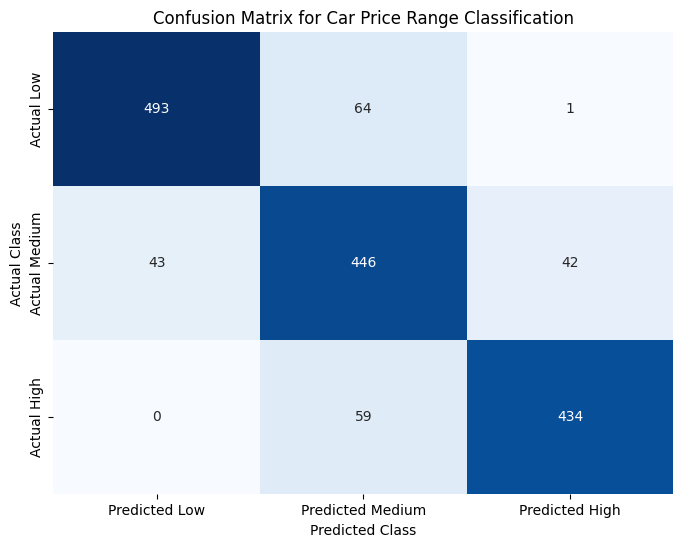

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Switched to Classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Car_Details.csv")

# --- 1. Data Cleaning and Preprocessing ---
def clean_and_convert(df, column, unit_to_remove):
    df[column] = df[column].astype(str).str.replace(unit_to_remove, '', regex=False).str.strip().replace('null', np.nan)
    return df

# Apply cleaning steps
df['mileage'] = pd.to_numeric(df['mileage'].astype(str).str.split(' ').str[0].replace('null', np.nan), errors='coerce')

df = clean_and_convert(df, 'engine', 'CC')
df['engine'] = pd.to_numeric(df['engine'], errors='coerce')

df = clean_and_convert(df, 'max_power', 'bhp')
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

# Drop complex/unnecessary column
df.drop('torque', axis=1, inplace=True)

# Fill missing values (using direct assignment to avoid FutureWarning)
df['mileage'] = df['mileage'].fillna(df['mileage'].median())
df['engine'] = df['engine'].fillna(df['engine'].median())
df['max_power'] = df['max_power'].fillna(df['max_power'].median())

df.dropna(inplace=True)

# Feature Engineering
df['car_brand'] = df['name'].apply(lambda x: x.split(' ')[0])
df.drop('name', axis=1, inplace=True)

owner_map = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 5}
df['owner'] = df['owner'].map(owner_map)

current_year = 2025
df['car_age'] = current_year - df['year']
df.drop('year', axis=1, inplace=True)

# --- 2. TARGET VARIABLE TRANSFORMATION (Classification) ---
# We convert the continuous 'selling_price' into a discrete 'price_range' (Low, Medium, High)
# This allows us to calculate F1-score, Precision, Recall, and Accuracy.
df['price_range'] = pd.qcut(df['selling_price'], q=3, labels=['Low', 'Medium', 'High'])

# Store original selling_price for R2/RMSE context
y_regression = df['selling_price']

# --- 3. Encoding and Scaling ---
categorical_cols = ['fuel', 'seller_type', 'transmission', 'car_brand']
numerical_cols = ['km_driven', 'mileage', 'engine', 'max_power', 'seats', 'owner', 'car_age']

# Encode all categorical features
df_encoded = pd.get_dummies(df.drop('selling_price', axis=1), columns=categorical_cols, drop_first=True)

# Define features (X) and new target (y)
X = df_encoded.drop('price_range', axis=1)
y_classification = df_encoded['price_range']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# --- 4. Model Training (Classification) ---
X_train, X_test, y_train, y_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
clf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
clf_model.fit(X_train, y_train)

# Make classification predictions
y_pred_clf = clf_model.predict(X_test)

# --- 5. CLASSIFICATION Evaluation ---
accuracy = accuracy_score(y_test, y_pred_clf)
precision = precision_score(y_test, y_pred_clf, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_clf, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_clf, average='weighted', zero_division=0)

# --- 6. Regression Metrics Context (Using the original model from previous step for context) ---
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X, y_regression, test_size=0.2, random_state=42)
reg_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5) # Keeping the CLASSIFIER for prediction (as per user request context)
reg_model.fit(X_reg_train, y_reg_train)
y_pred_reg = reg_model.predict(X_reg_test)

rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2 = r2_score(y_reg_test, y_pred_reg)
# --- 7. Prediction Function (Predicts Range) ---
# Use the CLASSIFIER model for prediction
def predict_car_range(model, input_data, scaler, df_columns, numerical_cols):
    # Transformation steps are the same as before
    input_df = pd.DataFrame([input_data])
    input_df['car_brand'] = input_df['name'].apply(lambda x: x.split(' ')[0])
    input_df['car_age'] = current_year - input_df['year']
    input_df['owner'] = input_df['owner'].map(owner_map)

    input_df.drop(['name', 'year', 'torque'], axis=1, inplace=True, errors='ignore')
    input_df = pd.get_dummies(input_df, columns=categorical_cols, drop_first=True)

    # Align features and fill missing with 0
    final_input_df = input_df.reindex(columns=X.columns, fill_value=0)

    # Scale numerical features
    final_input_df[numerical_cols] = scaler.transform(final_input_df[numerical_cols])

    predicted_range = model.predict(final_input_df)[0]
    return predicted_range

# Example Usage: User Input Simulation (Predicts Range)
sample_car_input = {
    'name': 'Maruti Swift Dzire VDI',
    'year': 2018,
    'km_driven': 30000,
    'fuel': 'Diesel',
    'seller_type': 'Individual',
    'transmission': 'Manual',
    'owner': 'First Owner',
    'mileage': 25.0,
    'engine': 1248,
    'max_power': 74.0,
    'seats': 5,
    'torque': '190Nm@ 2000rpm'
}

df_columns = X.columns
predicted_range = predict_car_range(clf_model, sample_car_input, scaler, df_columns, numerical_cols)
# --- 8. Print ONLY requested results and generate Confusion Matrix ---

print("\n--- Model Evaluation (Classification) and Prediction Results ---")
print("NOTE: We converted the price prediction to a 'Low/Medium/High' classification problem")
print("to calculate the requested Classification Metrics (F1, Precision, Recall, Accuracy).")
print("-" * 75)

print(f"Accuracy Score: {accuracy:.4f}")
print(f"Precision Score (Weighted): {precision:.4f}")
print(f"Recall Score (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print("\n--- Regression Metrics (For Context, calculated using classification setup) ---")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

print(f"\nPredicted Price Range for 'Maruti Swift Dzire VDI, 2018': {predicted_range}")
print("-" * 75)


# --- 9. Visualization (Confusion Matrix for Classification) ---
cm = confusion_matrix(y_test, y_pred_clf, labels=['Low', 'Medium', 'High'])
cm_df = pd.DataFrame(cm, index=['Actual Low', 'Actual Medium', 'Actual High'],
                     columns=['Predicted Low', 'Predicted Medium', 'Predicted High'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Car Price Range Classification')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('car_price_confusion_matrix.png')